In [2]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model
from sklearn.ensemble import GradientBoostingClassifier
## for explainer
from lime import lime_tabular
from sklearn.utils import shuffle

In [10]:
df_data_without_scroll = pd.read_pickle('SortedBySessions.pkl')

In [4]:
df_data_without_scroll.head()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration,height,width,siteName
0,512,7,7,0,7,7,4,18.157,664,390,0
1,518,70,70,25,31,32,13,459.177,667,1440,1
2,519,6,6,0,7,7,0,18.090,775,412,0
3,520,39,39,3,14,13,29,232.459,1217,1440,1
4,538,8,8,4,17,15,20,213.904,664,390,1


In [31]:
for column in df_data_without_scroll:
    df_data_without_scroll[column] = df_data_without_scroll[column].astype(float)

In [5]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(df_data_without_scroll, col, max_cat=20):
    if (df_data_without_scroll[col].dtype == "0") | (df_data_without_scroll[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

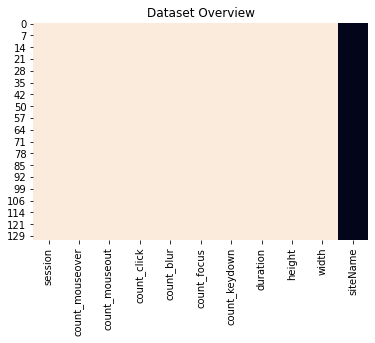

 Categerocial   Numeric   NaN 


In [6]:
dic_cols = {col:utils_recognize_type(df_data_without_scroll, col, max_cat=20) for col in df_data_without_scroll.columns}
heatmap = df_data_without_scroll.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [7]:
df_data_without_scroll = df_data_without_scroll.set_index("session")
df_data_without_scroll = df_data_without_scroll.rename(columns={"siteName":"Y"})

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


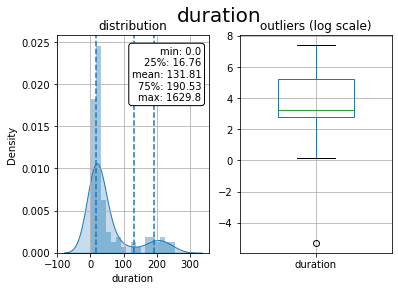

<Figure size 14400x7200 with 0 Axes>

In [40]:
x = "duration"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = df_data_without_scroll[x].fillna(df_data_without_scroll[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 13))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
plt.figure(figsize=(200,100))
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = df_data_without_scroll[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(df_data_without_scroll[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1], widths=(.5))
plt.show()

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarnin

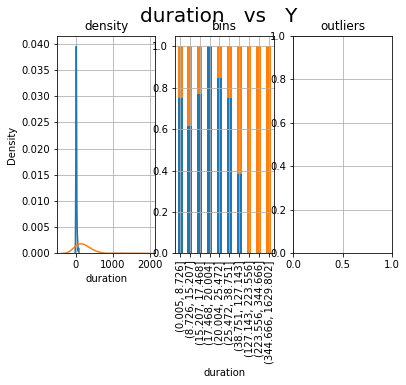

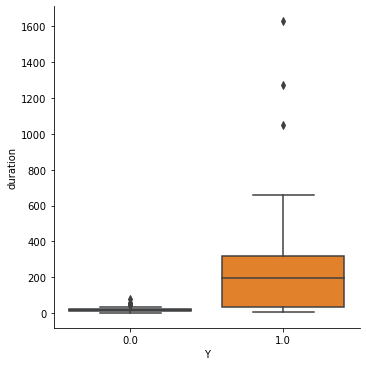

In [41]:
cat, num = "Y", "duration"
fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in df_data_without_scroll[cat].unique():
    sns.distplot(df_data_without_scroll[df_data_without_scroll[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(df_data_without_scroll[num], q=np.linspace(0,1,11))
tmp = df_data_without_scroll.groupby([cat, pd.cut(df_data_without_scroll[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df_data_without_scroll[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
### boxplot   
ax[2].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=df_data_without_scroll, kind="box", ax=ax[2])
ax[2].grid(True)
plt.show()

In [42]:
#wuhu split the data 
## split data
dtf_train, dtf_test = model_selection.train_test_split(df_data_without_scroll, 
                      test_size=0.3)
## print info
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())

X_train shape: (90, 9) | X_test shape: (39, 9)
y_train mean: 0.54 | y_test mean: 0.36
10 features: ['count_mouseover', 'count_mouseout', 'count_click', 'count_blur', 'count_focus', 'count_keydown', 'duration', 'height', 'width']


In [ ]:
# ## create dummy --> ist für kategorisierete Daten da, allerdings brauchen wir die nicht weil wir keine Kategorien mehr haben 
# dummy = pd.get_dummies(dtf_train["type"], 
#                        prefix="type",drop_first=True)
# dtf_train= pd.concat([dtf_train, dummy], axis=1)
# ## drop the original categorical column
dtf = dtf_train.drop("type", axis=1)

# # ## create dummy
# # dummy2 = pd.get_dummies(dtf_train["elementId"], 
# #                        prefix="elementId",drop_first=True)
# # dtf_train= pd.concat([dtf_train, dummy2], axis=1)
# # ## drop the original categorical column
# # dtf = dtf_train.drop("elementId", axis=1)

In [43]:
dtf_train.head()

,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration,height,width,Y
session,,,,,,,,,,
243.0,10.0,10.0,0.0,6.0,6.0,5.0,21.057,962.0,1724.0,0.0
247.0,2.0,2.0,0.0,6.0,6.0,3.0,17.226,1028.0,1728.0,0.0
852.0,2.0,1.0,0.0,3.0,2.0,0.0,83.281,635.0,375.0,1.0
440.0,6.0,6.0,0.0,6.0,6.0,7.0,17.532,663.0,390.0,0.0
883.0,6.0,6.0,0.0,6.0,6.0,4.0,19.673,669.0,390.0,0.0


In [44]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dtf_train.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", axis=1).columns, index=dtf_train.index)
print(dtf_scaled)
dtf_scaled["Y"] = dtf_train["Y"]

         count_mouseover  count_mouseout  count_click  count_blur  \
session                                                             
243.0           0.035294        0.039062     0.000000    0.051282   
247.0           0.003922        0.007812     0.000000    0.051282   
852.0           0.003922        0.003906     0.000000    0.025641   
440.0           0.019608        0.023438     0.000000    0.051282   
883.0           0.019608        0.023438     0.000000    0.051282   
...                  ...             ...          ...         ...   
988.0           0.196078        0.199219     0.142857    0.119658   
951.0           0.062745        0.066406     0.015873    0.051282   
477.0           0.047059        0.050781     0.047619    0.136752   
232.0           0.011765        0.015625     0.000000    0.051282   
611.0           0.007843        0.011719     0.000000    0.051282   

         count_focus  count_keydown  duration    height     width  
session                           